<a href="https://colab.research.google.com/github/deansaco/Traffic_Sign_Classifier/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np
from glob import glob
import os
import pickle
import math
import random
import csv
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle


print('All modules imported.')

All modules imported.


# 1 Reload the preprocessed data

In [ ]:
# 1 Reload the preprocessed data

pickle_file = './traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory


# def get_image(path, img_rows, img_cols, color_type=3): #get image
#     img = cv2.imread(path,1)
#     resized = cv2.resize(img, (img_rows, img_cols)) # Reduce size (img_rows, img_cols)
#     return resized
# #------------------------------------------------train------------------------------------------------------------------------------
# def load_train(img_rows, img_cols, color_type=3): #train images and train labels
#     train_images = [] 
#     train_labels = []
#     for classes in range(0,42):
#         print('Loading directory c{}'.format(classes))
#         files = glob(os.path.join('/Users/deansacoransky/Desktop/Traffic-Sign-Classifier-master/data/Train/' + str(classes), '*.jpg'))
#         for file in files:
#             img = get_image(file, img_rows, img_cols, color_type)
#             train_images.append(img)
#             train_labels.append(classed)
#     return train_images, train_labels     
    
# train_images, train_labels  = load_train(224,224)

    
# temp = []
# count = 0
# for image in X_valid:
#     resized_test=cv2.resize(image, (224,224))
#     #print(resized_test.shape)
#     resized_test = resized_test[np.newaxis]
#     #print("/////", resized_test.shape)
#     resized_test  = list(resized_test)
#     #resized_test= np.insert(resized_test,0, count, axis = 0)
#     resized_test.insert(0, count)
#     print(len(resized_test))
#     #temp = np.append(temp, resized_test,axis = 0)
#     temp.append(resized_test)
#    #print(temp.shape)
#     #print("array size", temp.shape)
#     count += 1
#     #print(count)
# temp = np.array(temp)
# print(temp.shape)

# for image in X_valid:
#     resized_valid=cv2.resize(image, (224,224))
#     X_valid=resized_valid

#X_train = resize(X_train)
#X_test = resize(X_test)
# X_valid = resize(X_valid)
#print(X_train.shape, y_train.shape)
# print(X_valid.shape, y_valid.shape)
#print(X_test.shape, y_test.shape)

In [ ]:
reshaped_images = []
for image in X_valid:
    image_reshape = cv2.resize(image,(224, 224), interpolation = cv2.INTER_CUBIC)
    reshaped_images.append(image_reshape)

In [ ]:
print(image_reshape.shape)

(224, 224, 3)


In [ ]:
# def resize(set):
#     for image in set:
#         cv2.resize(image, (224,224))
#     return set
# resize(X_train)

In [ ]:
print(X_train.shape)
#print(X_train.shape, y_train.shape)
# print(X_valid.shape, y_valid.shape)
# print(X_test.shape, y_test.shape)

(34799, 32, 32, 3)


(224, 224, 3)


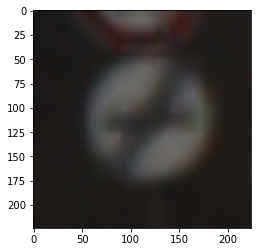

In [ ]:
resized =cv2.resize(X_train[1], (224,224))
plt.imshow(resized)
print(resized.shape)


In [ ]:
for i in X_train:
    resized =cv2.resize(X_train[i], (224,224))
    resized = img_to_array(resized_image)
    print(resized.shape)
    data.append(resized)


error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:3688: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [ ]:
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


In [ ]:
# #convert output into one hot encoded vector
y_train = tf.one_hot(y_train, 43)
y_valid = tf.one_hot(y_valid, 43)
y_test = tf.one_hot(y_test, 43)

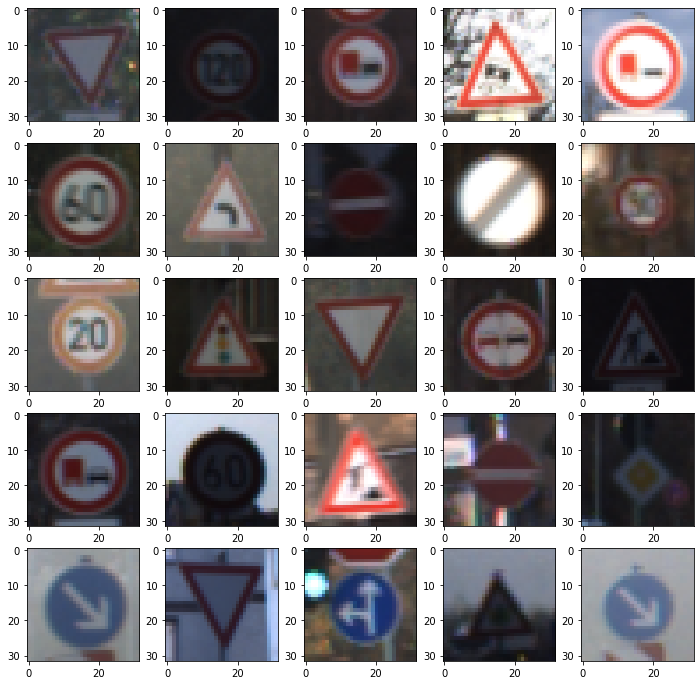

In [ ]:
plt.figure(figsize=(12,12))
# plot first few images
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# 2 Model Architecture

## 2.1 Inception model and GoogLeNet

In [ ]:
def googlenet(input_shape, n_classes):
    
    def inception_block(x, f):
        
        t1 = Conv2D(f[0], 1, activation='relu')(x)

        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)

        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)

        output = Concatenate()([t1, t2, t3, t4])
        return output
    
    input = Input(input_shape)
  
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
  
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)

    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])

    x = AvgPool2D(7, strides=1)(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    
    LEARNING_RATE=5e-4
    
    
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, name='Adam')
    loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=opt,loss=loss_function, metrics=['acc'])
    

    return model

In [ ]:
input_shape=224,224,3
n_classes=43
Gnet=googlenet(input_shape,n_classes)

history = Gnet.fit(X_train, y_train, 
                         epochs=30, 
                         batch_size=128, 
                         validation_data=(X_test, y_test),
                         callbacks=[cp_callback])

ValueError: Exception encountered when calling layer "average_pooling2d_2" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 4 for '{{node average_pooling2d_2/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 1, 1, 1]](Placeholder)' with input shapes: [?,4,4,1024].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 4, 4, 1024), dtype=float32)

In [ ]:
# def create_model():
#     GoogleNet=tf.keras.Sequential(layers=[Conv2D(64, 7, strides=2, activation=ReLU(), padding='same'),
#                             MaxPool2D(3, strides=2, padding='same'),
#                             Conv2D(64, 1, activation='relu'),
#                             Conv2D(192, 3, padding='same', activation='relu'), 
#                             MaxPool2D(3, strides=2),
#                             inception_block(x, [64, 96, 128, 16, 32, 32]),
#                             inception_block(x, [128, 128, 192, 32, 96, 64]),
#                             MaxPool2D(3, strides=2, padding='same'),
#                             inception_block(x, [192, 96, 208, 16, 48, 64]),
#                             inception_block(x, [160, 112, 224, 24, 64, 64]), 
#                             inception_block(x, [128, 128, 256, 24, 64, 64]),
#                             inception_block(x, [112, 144, 288, 32, 64, 64]),
#                             inception_block(x, [256, 160, 320, 32, 128, 128]),
#                             MaxPool2D(3, strides=2, padding='same'),
#                             inception_block(x, [256, 160, 320, 32, 128, 128]),
#                             inception_block(x, [384, 192, 384, 48, 128, 128]),
#                             AvgPool2D(7, strides=1, padding='same'),
#                             Dropout(0.4),
#                             Flatten(),
#                             Dense(43, activation='softmax')])

In [ ]:
checkpoint_path="trained_GoogleNet/cp.ckpt"
checkpoint_dir=os.path.dirname(checkpoint_path)

cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                               save_weights_only=True,
                                               verbose=1)

GoogleNet=create_model()

#fit model
history = GoogleNet.fit(X_train, y_train, 
                         epochs=30, 
                         batch_size=128, 
                         validation_data=(X_test, y_test),
                         callbacks=[cp_callback])

NameError: name 'create_model' is not defined

In [ ]:
# def Inception(inputs, conv11_size, conv33_11_size, conv33_size,conv55_11_size, conv55_size, pool11_size):
#     conv11 = layers.conv2d(inputs, conv11_size, [1, 1])
#     conv33_reduce = layers.conv2d(inputs, conv33_11_size, [1, 1])
#     conv33 = layers.conv2d(conv33_reduce, conv33_size, [3, 3])
#     conv55_reduce = layers.conv2d(inputs, conv55_11_size, [1, 1])
#     conv55 = layers.conv2d(conv55_reduce, conv55_size, [5, 5])
#     pool_proj = layers.max_pool2d(inputs, [3, 3], stride = 1, padding='SAME')
#     pool11 = layers.conv2d(pool_proj, pool11_size, [1, 1])
#     return tf.concat([conv11, conv33, conv55, pool11], 3)

# def GoogLeNet(inputs, dropout_keep_prob): # inputs size:32x32x3
#     conv1 = layers.conv2d(inputs, 64, [3, 3], stride = 2) # 16x16x64
    
#     inception_2a = Inception(conv1, 64, 96, 128, 16, 32, 32) # 16x16x256
#     inception_2b = Inception(inception_2a, 128, 128, 192, 32, 96, 64) # 16x16x480
#     pool2 = layers.max_pool2d(inception_2b, [3, 3]) # 7x7x480 ? why
    
#     inception_3a = Inception(pool2, 192, 96, 208, 16, 48, 64) # 7x7x512
#     inception_3b = Inception(inception_3a, 160, 112, 224, 24, 64, 64) # 7x7x512
#     pool3 = layers.max_pool2d(inception_3b, [3, 3]) # 3x3x512
    
#     inception_4a = Inception(pool3, 256, 160, 320, 32, 128, 128) # 3x3x832
#     inception_4b = Inception(inception_4a, 384, 192, 384, 48, 128, 128) # 3x3x1024
#     pool4 = layers.avg_pool2d(inception_4b, [3, 3], stride = 1) 

#     reshape = tf.reshape(pool4, [-1, 1024])
#     dropout = layers.dropout(reshape, dropout_keep_prob)
#     logits = layers.fully_connected(dropout, 43, activation_fn=None)
    
#     return logits

# 3 Training

## 3.1 Strategy

In [ ]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 4e-4
EPOCHS = 35
BATCH_SIZE = 128

# Train method
logits = GoogLeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
train_op = optimizer.minimize(loss_op)

## 3.2 Evaluation

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_op, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 3.3 Train the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
%%time
saver = tf.train.Saver()
train_accuracy = []
valid_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_train_acc = 0
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_acc = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            total_train_acc += (train_acc * len(batch_x))
        train_accuracy.append(total_train_acc / num_examples)
        valid_acc = evaluate(X_valid, y_valid)
        valid_accuracy.append(valid_acc)
        print("Validation Accuracy = {:.3f}".format(valid_acc))
        
    saver.save(sess, './model/googlenet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Validation Accuracy = 0.460
EPOCH 2 : Validation Accuracy = 0.878
EPOCH 3 : Validation Accuracy = 0.903
EPOCH 4 : Validation Accuracy = 0.948
EPOCH 5 : Validation Accuracy = 0.952
EPOCH 6 : Validation Accuracy = 0.951
EPOCH 7 : Validation Accuracy = 0.951
EPOCH 8 : Validation Accuracy = 0.948
EPOCH 9 : Validation Accuracy = 0.950
EPOCH 10 : Validation Accuracy = 0.968
EPOCH 11 : Validation Accuracy = 0.959
EPOCH 12 : Validation Accuracy = 0.956
EPOCH 13 : Validation Accuracy = 0.965
EPOCH 14 : Validation Accuracy = 0.972
EPOCH 15 : Validation Accuracy = 0.968
EPOCH 16 : Validation Accuracy = 0.952
EPOCH 17 : Validation Accuracy = 0.973
EPOCH 18 : Validation Accuracy = 0.975
EPOCH 19 : Validation Accuracy = 0.959
EPOCH 20 : Validation Accuracy = 0.977
EPOCH 21 : Validation Accuracy = 0.978
EPOCH 22 : Validation Accuracy = 0.973
EPOCH 23 : Validation Accuracy = 0.983
EPOCH 24 : Validation Accuracy = 0.977
EPOCH 25 : Validation Accuracy = 0.979
EPOCH 26 : Validation 

#### Plot the accuracy of training and validation operation

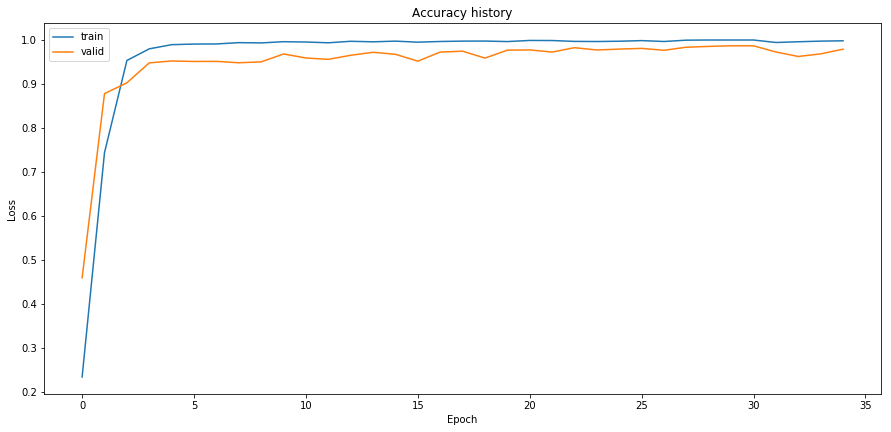

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 15)
plt.legend()
plt.show()

# 4 Testing

## 4.1 Test the model on testing dataset

In [ ]:
saver = tf.train.import_meta_graph('./model/googlenet.ckpt.meta')
with tf.Session() as sess:
    saver.restore(sess, './model/googlenet.ckpt')

INFO:tensorflow:Restoring parameters from ./model/googlenet.ckpt


INFO:tensorflow:Restoring parameters from ./model/googlenet.ckpt


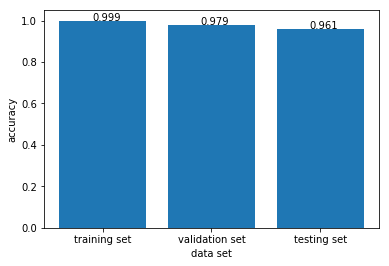

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './model/googlenet.ckpt')
#     sess.run(tf.global_variables_initializer())
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

## 4.2 Test the Model on New Images

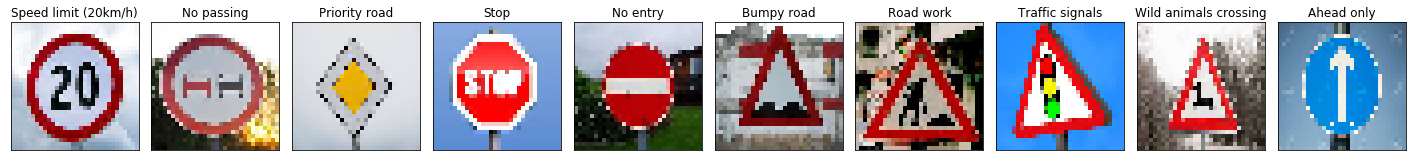

In [ ]:
online_images = []
online_labels = [0, 9, 12, 14, 17, 22, 25, 26, 31, 35]

for i in range(1, 11):
    image = plt.imread('./test_images/' + str(i) +'.jpeg')
    image_reshape = cv2.resize(image,(32, 32), interpolation = cv2.INTER_CUBIC)
    online_images.append(image_reshape)

plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace = .1, wspace=.1)
for i in range(len(online_images)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(online_images[i])
    plt.title(signnames[int(online_labels[i])])
    plt.xticks([]), plt.yticks([])
plt.savefig('./result_images/online image.jpg')

online_images = np.array(online_images)
online_images = online_images.astype(np.float32) / 128. - 1.
online_labels = np.array(online_labels)

### Predict the Sign Type for Each Image

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './model/googlenet.ckpt')
    test_accuracy = evaluate(online_images, online_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))   
    logits_value = sess.run(logits, feed_dict={x: online_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from ./model/googlenet.ckpt
Test Accuracy = 1.000
Predict the Sign Type for Each Image
[ 0  9 12 14 17 22 25 26 31 35]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

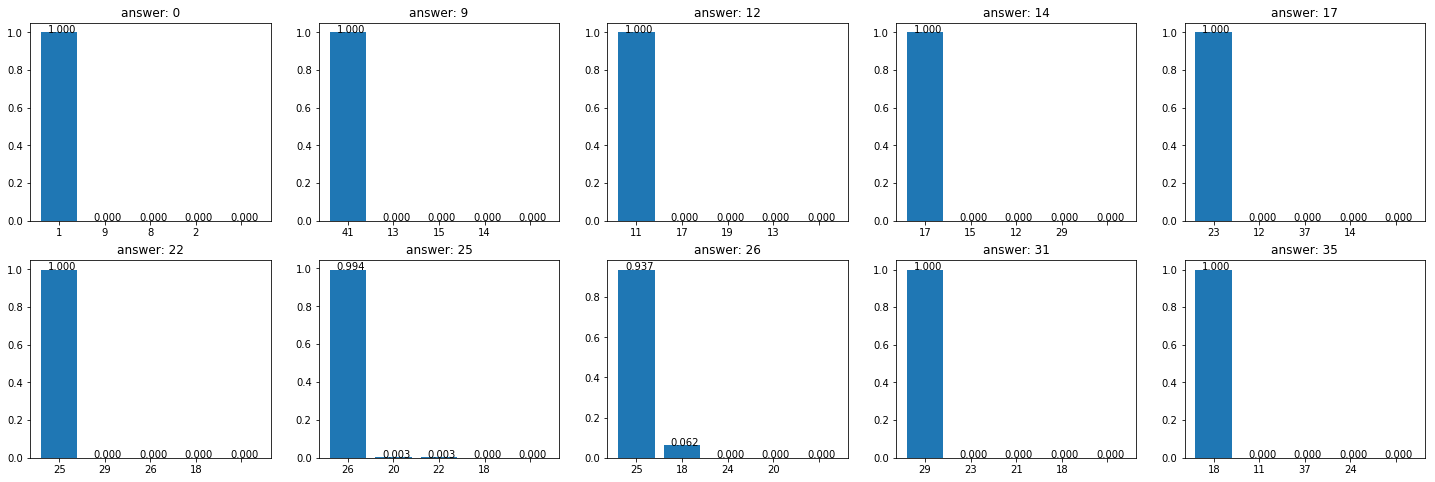

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

values = top5.values
indices = top5.indices
fig, axes = plt.subplots(2, 5, figsize=(25, 8))
for i in range(2):
    for j in range(5):
        axes[i][j].bar(range(5), values[i*5+j])
        axes[i][j].set_xticklabels(indices[i*5+j])
        axes[i][j].set_title("answer: "+str(online_labels[i*5+j]))
        for x_,y_ in zip(range(5), values[i*5+j]):
            axes[i][j].text(x_ - 0.25, y_, '%.3f'%y_)